## Libraries

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import pandas
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import os
import matplotlib.pyplot as plt
import sys
from IPython.display import display, Image
from scipy import ndimage,misc
from sklearn.linear_model import LogisticRegression
from six.moves import cPickle as pickle


## Load images

In [2]:
dataPath='/home/lex/MEGAsync/2_UdeA/Algas_2/1_data/'
image_size = 112# Pixel width and height.
number_image_channels=3
pixel_depth = 255.0  # Number of levels per pixel.
dataAugmentationFactor=4

def load_imageSet(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files*dataAugmentationFactor), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
    
      image_data1 = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
    
      image_data =misc.imresize(image_data1,[image_size,image_size])
       
      #print(image_data.shape,image)
      if image_data.shape != (image_size, image_size):
          image_data =(image_data[:,:,0]+image_data[:,:,1]+image_data[:,:,2])/number_image_channels
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        
      # Data augmentation
      # Flip
        
      dataset[num_images, :, :] = image_data
      dataset[num_images+1, :, :] = np.fliplr(image_data)
      dataset[num_images+2, :, :] = np.flipud(image_data)
      dataset[num_images+3, :, :] =np.flipud(np.fliplr(image_data))
    
    
    
      num_images = num_images + 4
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset

# load data in vector shape
#train - data
trainSet1 = load_imageSet(dataPath+'train/1', 100)
trainSet2 = load_imageSet(dataPath+'train/2', 100)
trainSet4 = load_imageSet(dataPath+'train/4', 100)
trainSet8 = load_imageSet(dataPath+'train/8', 100)
trainSet=np.concatenate((trainSet1,trainSet2,trainSet4,trainSet8), axis=0)
trainSetLabels=np.concatenate((np.zeros(len(trainSet1)),np.ones(len(trainSet2))
                               ,np.ones(len(trainSet4))*2,np.ones(len(trainSet8))*3), axis=0)
#validation - data
validationSet1 = load_imageSet(dataPath+'validation/1', 80)
validationSet2 = load_imageSet(dataPath+'validation/2', 80)
validationSet4 = load_imageSet(dataPath+'validation/4', 80)
validationSet8 = load_imageSet(dataPath+'validation/8', 80)
valSet=np.concatenate((validationSet1,validationSet2,validationSet4,validationSet8), axis=0)
valSetLabels=np.concatenate((np.zeros(len(validationSet1)),np.ones(len(validationSet2))
                               ,np.ones(len(validationSet4))*2,np.ones(len(validationSet8))*3), axis=0)
#test - data
testSet1 = load_imageSet(dataPath+'test/1', 30)
testSet2 = load_imageSet(dataPath+'test/2', 30)
testSet4 = load_imageSet(dataPath+'test/4', 30)
testSet8 = load_imageSet(dataPath+'test/8', 30)
testSet=np.concatenate((testSet1,testSet2,testSet4,testSet8), axis=0)
testSetLabels=np.concatenate((np.zeros(len(testSet1)),np.ones(len(testSet2))
                               ,np.ones(len(testSet4))*2,np.ones(len(testSet8))*3), axis=0)

/home/lex/MEGAsync/2_UdeA/Algas_2/1_data/train/1
Full dataset tensor: (1204, 112, 112)
Mean: 4.3501
Standard deviation: 23.6169
/home/lex/MEGAsync/2_UdeA/Algas_2/1_data/train/2
Full dataset tensor: (1200, 112, 112)
Mean: 8.1774
Standard deviation: 31.8718
/home/lex/MEGAsync/2_UdeA/Algas_2/1_data/train/4
Full dataset tensor: (1196, 112, 112)
Mean: 14.9362
Standard deviation: 42.5512
/home/lex/MEGAsync/2_UdeA/Algas_2/1_data/train/8
Full dataset tensor: (1080, 112, 112)
Mean: 36.6454
Standard deviation: 63.1382
/home/lex/MEGAsync/2_UdeA/Algas_2/1_data/validation/1
Full dataset tensor: (320, 112, 112)
Mean: 3.959
Standard deviation: 22.1975
/home/lex/MEGAsync/2_UdeA/Algas_2/1_data/validation/2
Full dataset tensor: (320, 112, 112)
Mean: 8.77513
Standard deviation: 33.23
/home/lex/MEGAsync/2_UdeA/Algas_2/1_data/validation/4
Full dataset tensor: (320, 112, 112)
Mean: 13.7213
Standard deviation: 40.7339
/home/lex/MEGAsync/2_UdeA/Algas_2/1_data/validation/8
Full dataset tensor: (440, 112, 112)


## Reshape

In [3]:
image_size = 112
num_labels = 4
num_channels = 1 # grayscale

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(trainSet, trainSetLabels)
valid_dataset, valid_labels = reformat(valSet, valSetLabels)
test_dataset, test_labels = reformat(testSet, testSetLabels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


Training set (4680, 112, 112, 1) (4680, 4)
Validation set (1400, 112, 112, 1) (1400, 4)
Test set (480, 112, 112, 1) (480, 4)


In [4]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

## Define computational graph

In [34]:
batch_size = 100
conv1_kernel = 3
conv2_kernel = 3
conv3_kernel = 3
depth = 16
depthLayer2 = 32
depthLayer3 = 32
num_hidden = 100

## Optimization parameters
reg=0.005
learningRate=0.001
global_step=50000
momentum=0.5

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  ## Variables.
  #Conv1 - Kernels
  layer1_weights = tf.Variable(tf.truncated_normal(
      [conv1_kernel, conv1_kernel, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  #Conv2 - Kernels  
  layer2_weights = tf.Variable(tf.truncated_normal(
      [conv2_kernel, conv2_kernel, depth, depthLayer2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depthLayer2]))

  #Conv3 - Kernels  
  layer2_1_weights = tf.Variable(tf.truncated_normal(
      [conv3_kernel, conv3_kernel, depthLayer3, depthLayer3], stddev=0.1))
  layer2_1_biases = tf.Variable(tf.constant(1.0, shape=[depthLayer3]))

  # full-connected
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 8 * image_size // 8 * depthLayer3, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

## shape verification
  
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    pool1=tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    
    conv = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden2 = tf.nn.relu(conv + layer2_biases)
    pool2=tf.nn.max_pool(hidden2, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    
    print(pool2.get_shape(),layer2_1_weights.get_shape()) 
    conv = tf.nn.conv2d(pool2, layer2_1_weights, [1, 1, 1, 1], padding='SAME')
    hidden3 = tf.nn.relu(conv + layer2_1_biases)
    pool3=tf.nn.max_pool(hidden3, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    
    shape = pool3.get_shape().as_list()
    reshape = tf.reshape(pool3, [shape[0], shape[1] * shape[2] * shape[3]])
    
    pool = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(pool, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))+reg*tf.nn.l2_loss(layer1_weights)+reg*tf.nn.l2_loss(layer2_weights)+reg*tf.nn.l2_loss(layer3_weights)+reg*tf.nn.l2_loss(layer4_weights)
    
  # Optimizer
  decarLR=tf.train.exponential_decay(learningRate,global_step,100000, 0.96)
  optimizer = tf.train.MomentumOptimizer(decarLR,momentum).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

(100, 28, 28, 32) (3, 3, 32, 32)
(1400, 28, 28, 32) (3, 3, 32, 32)
(480, 28, 28, 32) (3, 3, 32, 32)


## Running

In [ ]:
num_steps = 1500

with tf.Session(graph=graph) as session:
  init_new_vars_op =tf.initialize_all_variables()
  session.run(init_new_vars_op)
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 32.474979
Minibatch accuracy: 42.0%
Validation accuracy: 32.9%
Minibatch loss at step 50: 12.800685
Minibatch accuracy: 75.0%
Validation accuracy: 75.9%
Minibatch loss at step 100: 12.650283
Minibatch accuracy: 84.0%
Validation accuracy: 80.2%
Minibatch loss at step 150: 12.736807
Minibatch accuracy: 73.0%
Validation accuracy: 82.2%


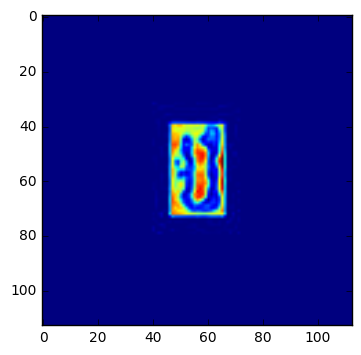

In [63]:
#image_data0 = (ndimage.imread(dataPath+'train/1.jpg').astype(float) - 
#                    pixel_depth / 2) / pixel_depth



imgplot = plt.imshow(train_dataset[9,:,:,0])
plt.show(imgplot)


In [ ]:
batch_size = 100
patch_size = 5
depth = 16
depthLayer2 = 32
num_hidden = 150

## Optimization parameters
reg=0.0005
learningRate=0.001
global_step=50000

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depthLayer2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depthLayer2]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depthLayer2, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

## shape verification
  
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    pool=tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden2 = tf.nn.relu(conv + layer2_biases)
    pool=tf.nn.max_pool(hidden2, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    print(layer2_weights.get_shape())
    pool = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(pool, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))+reg*tf.nn.l2_loss(layer1_weights)+reg*tf.nn.l2_loss(layer2_weights)+reg*tf.nn.l2_loss(layer3_weights)+reg*tf.nn.l2_loss(layer4_weights)
    
  # Optimizer
  decarLR=tf.train.exponential_decay(learningRate,global_step,100000, 0.96)
  optimizer = tf.train.GradientDescentOptimizer(decarLR).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))